## Spot Analysis of BF Correction

Originally written by Alex Broughton

Using Run 12788 for spot, we use images from the seq_num IN (463 503 543 583 623 663 703 743 763). We use calibration products from run 12781 do complete the BF correction in the ISR Task.


In [1]:
! eups list -s | grep lsst_distrib

eups                  LOCAL:/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2021_21/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0-ext/eups 	setup
lsst_distrib          21.0.0-2-g8e5b5ee+0374c0674c 	w_latest current w_2021_21 setup


In [2]:
import os
import numpy as np
import glob
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table, vstack, join
from astropy.table.table_helpers import simple_table
from scipy import stats
from scipy.optimize import curve_fit

In [3]:
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/butler.yaml"

butler = Butler(repo_path)
registry = butler.registry

In [4]:
def getData(repo, collection, fluxkey="base_CircularApertureFlux_70_0_instFlux", shapekey="base_SdssShape_xx"):
    # Pulls out data from run and returns BF table
    
    # Get the BF-corrected butler
    col = "".join((collection, 'wbfcorr'))

    subbutler_corr = Butler(repo_path,collections=col)
    subregistry_corr = subbutler_corr.registry

    datasetRefs_corr = list(subregistry_corr.queryDatasets(
        datasetType="gridSpotSrc",
        collections=col))
    
    # Get the non-BF-corrected butle
    col = "".join((collection, 'wobfcorr'))

    subbutler_uncorr = Butler(repo_path,collections=col)
    subregistry_uncorr = subbutler_uncorr.registry

    datasetRefs_uncorr = list(subregistry_uncorr.queryDatasets(
        datasetType="gridSpotSrc",
        collections=col))
    

    tab_corr = []
    tab_uncorr = []
    for i, aref in enumerate(datasetRefs_corr):

        # postISRCCD
        raw = subbutler_corr.get("raw",dataId=aref.dataId)
        md = raw.getMetadata()
        exptime = md["EXPTIME"]

        if exptime > 20.0: 
            continue
        
        
        try:
            subbutler_corr.datasetExists("gridSpotSrc",dataId=aref.dataId)
            subbutler_uncorr.datasetExists("gridSpotSrc",dataId=aref.dataId)
        except:
            continue
        
        
        for subbutler, tab in zip([subbutler_corr, subbutler_uncorr], [tab_corr,tab_uncorr]):
            src = subbutler.get("gridSpotSrc",dataId=aref.dataId)
            mdsrc = src.getMetadata()
            x0 = mdsrc['GRID_X0']
            y0 = mdsrc['GRID_Y0']

            # Craig's cuts
            minSizeX = 4.0
            maxSizeX = 7.0
            minSizeY = 4.0
            maxSizeY = 7.0
            minFluxRatio = 0.80
            maxFlux = np.nanmax(src['base_SdssShape_instFlux'])
            select = src['base_SdssShape_instFlux'] > maxFlux * minFluxRatio
            spotCatalog  = src.subset(select)
            select = ((src['base_SdssShape_xx'] >= minSizeX) & (src['base_SdssShape_xx'] <= maxSizeX) & 
                    (src['base_SdssShape_yy'] >= minSizeY) & (src['base_SdssShape_yy'] <= maxSizeY))

            src  = src.subset(select)

            # Center cuts
            maxradius = 10.*np.mean([mdsrc["GRID_XSTEP"], mdsrc["GRID_YSTEP"]])
            distances = np.sqrt((src["spotgrid_x"] - x0)**2 + (src["spotgrid_y"] - y0)**2)
            mask1 = (distances <= maxradius)

            # NaN cuts
            mask0 = (src['spotgrid_index'] >= 0)

            src = src[mask0 & mask1]

            # Get the peak spot values
            maxADC = np.zeros(len(src))
            s = 15
            if len(src) > 0:
                postisr = subbutler.get("postISRCCD",dataId=aref.dataId)
                image = postisr.getImage().getArray()
                #image = raw.getImage().getArray()
                for i,pt in enumerate(src["spotgrid_index"]):
                    x = int(src['spotgrid_y'][i]) # The coordinate systems are flipped
                    y = int(src['spotgrid_x'][i])
                    xmin = max(0,x-s)
                    xmax = min(image.shape[0]-1, x+s)
                    ymin = max(0,y-s)
                    ymax = min(image.shape[1]-1, y+s)
                    maxADC[i] = np.max(image[xmin:xmax,ymin:ymax])


            if len(src) > 0:
                indxs = np.argsort(src['spotgrid_index'])
                tab.append(
                    {
                        "index": i,
                        "dataId": aref.dataId,
                        "exptime": exptime,
                        "numspots" : len(src),
                        "spot_indices": src['spotgrid_index'][indxs],
                        "spotgrid_x": src['spotgrid_x'][indxs],
                        "spotgrid_y": src['spotgrid_y'][indxs],
                        "base_SdssShape_xx": src['base_SdssShape_xx'][indxs],
                        "base_SdssShape_yy": src['base_SdssShape_yy'][indxs],
                        "base_PsfFlux_instFlux": src["base_PsfFlux_instFlux"][indxs],
                        "base_CircularApertureFlux_3_0_instFlux": src["base_CircularApertureFlux_3_0_instFlux"][indxs],
                        "base_CircularApertureFlux_70_0_instFlux": src["base_CircularApertureFlux_70_0_instFlux"][indxs],
                        "maxADC": maxADC[indxs]
                    }
                )

    t_corr = Table(tab_corr)
    t_sorted_corr = t_corr[np.argsort(t_corr['exptime'])]
    
    t_uncorr = Table(tab_uncorr)
    t_sorted_uncorr = t_uncorr[np.argsort(t_uncorr['exptime'])]

    return t_sorted_corr, t_sorted_uncorr


#### PTC Curve

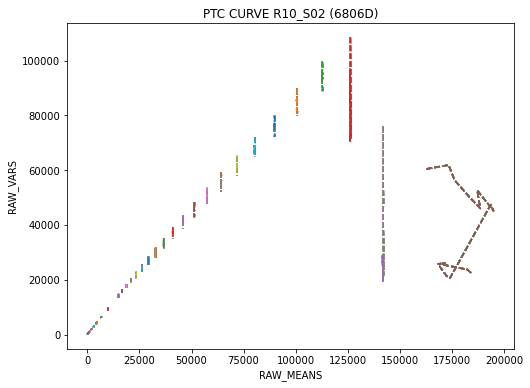

In [5]:
ptcdir = "/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/u/abrought/run_12781/bf_work_v5/polynomialfit/ptcs/20210622T200720Z/ptc/"
ptcfile = glob.glob(ptcdir + "*R10_S02*.fits")[0]
hdu = fits.open(ptcfile)
hdu[1].columns

plt.figure(1, figsize=(8,6),facecolor="w")
for amp in hdu[1].data:
    plt.plot(hdu[1].data['RAW_MEANS'], hdu[1].data['RAW_VARS'], "--")
    plt.xlabel("RAW_MEANS")
    plt.ylabel("RAW_VARS")
    plt.title("PTC CURVE R10_S02 (6806D)")

#### With BF Correction

Plotted for all spots.
* Note that the 50sec exposure points are almost all masked out because they are all saturated.

In [13]:
tab_corr, tab_uncorr = getData(repo=repo_path, collection='u/abrought/run_12781/bf_work_v5/polynomialfit/spots_v13/')

filename_wbfcorr = "./plots/itl-R10_S02-25raft-moredata/polynomialfit/centerspots/data_wbfcorr.pkl"
filename_wobfcorr = "./plots/itl-R10_S02-25raft-moredata/polynomialfit/centerspots/data_wobfcorr.pkl"

# Pickle BF-corrected data
if(os.path.isfile(filename_wbfcorr)):
    os.remove(filename_wbfcorr)
        
with open(filename_wbfcorr, 'wb') as f:
    print("Jarring a new data pickle:", filename_wbfcorr)
    names = tab_corr.colnames
    pkl.dump([dict(zip(names, row)) for row in tab_corr], f)
    pkl.dump([dict(zip(names, row)) for row in tab_corr], f)
    print("Done.")

# Pickle BF-corrected data
if(os.path.isfile(filename_wobfcorr)):
    os.remove(filename_wobfcorr)
        
with open(filename_wobfcorr, 'wb') as f:
    print("Jarring a new data pickle:", filename_wobfcorr)
    names = tab_uncorr.colnames
    pkl.dump([dict(zip(names, row)) for row in tab_uncorr], f)
    pkl.dump([dict(zip(names, row)) for row in tab_uncorr], f)
    print("Done.")

/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000581/MC_C_20201126_000581_R10_S02.fits(MC_C_20201126_000581): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000458/MC_C_20201126_000458_R10_S02.fits(MC_C_20201126_000458): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000496/MC_C_20201126_000496_R10_S02.fits(MC_C_20201126_000496): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000649/MC_C_20201126_000649_R10_S02.fits(MC_C_20201126_000649): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000457/MC_C_20201126_000457_R10_S02.fits(MC_C_20201126_000457): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000609/MC_C_20201126_000609_R10_S02.fits(MC_C_20201126_000609): Unable to determine the filte

Jarring a new data pickle: ./plots/itl-R10_S02-25raft-moredata/polynomialfit/centerspots/data_wbfcorr.pkl
Done.
Jarring a new data pickle: ./plots/itl-R10_S02-25raft-moredata/polynomialfit/centerspots/data_wobfcorr.pkl
Done.


In [4]:
filename_wbfcorr = "./plots/itl-R10_S02-25raft-moredata/polynomialfit/centerspots/data_wbfcorr.pkl"
filename_wobfcorr = "./plots/itl-R10_S02-25raft-moredata/polynomialfit/centerspots/data_wobfcorr.pkl"
tab_corr = Table(pkl.load( open(filename_wbfcorr, "rb") )).group_by('exptime')
tab_uncorr = Table(pkl.load( open(filename_wobfcorr, "rb") )).group_by('exptime')

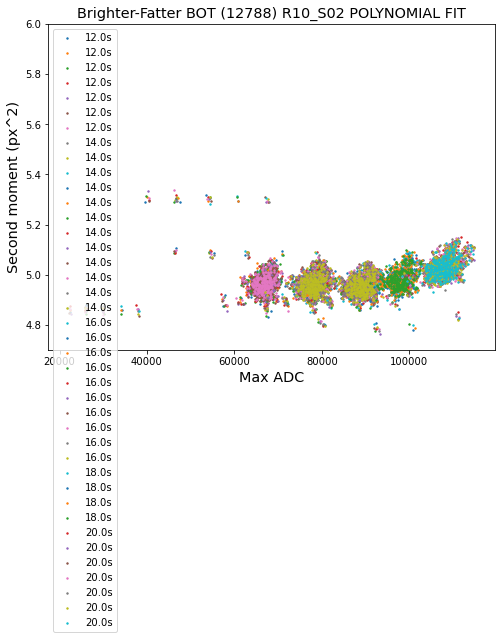

In [15]:
plt.figure(2, figsize=(8,6),facecolor="w")           
plt.title("Brighter-Fatter BOT (12788) R10_S02 POLYNOMIAL FIT", fontsize='x-large')

median_flux = []
median_shape = []
for t in tab_corr:
    median_flux.append(np.median(t['maxADC']))
    median_shape.append(np.median(t['base_SdssShape_xx']))
    plt.scatter(t['maxADC'], t['base_SdssShape_xx'], s=2, label=str(t['exptime']) + 's')

plt.legend()
plt.ylim(4.7,6.0)
plt.xlabel("Max ADC", fontsize='x-large')
plt.ylabel("Second moment (px^2)", fontsize='x-large')
plt.savefig("./plots/itl-R10_S02-25raft-moredata/polynomialfit/centerspots/secondmoment_flux.png")

#### Without BF Correction

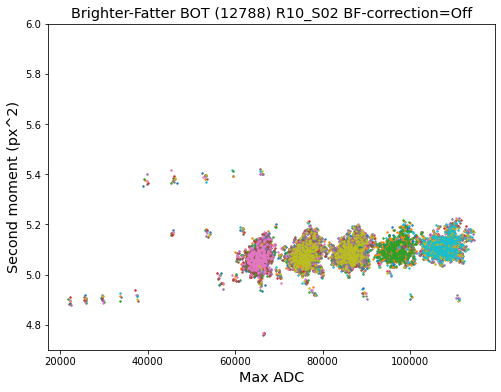

In [7]:
plt.figure(3, figsize=(8,6),facecolor="w") 
plt.title("Brighter-Fatter BOT (12788) R10_S02 BF-correction=Off", fontsize='x-large')

median_flux = []
median_shape = []
for t in tab_uncorr:
    median_flux.append(np.median(t['maxADC']))
    median_shape.append(np.median(t['base_SdssShape_xx']))
    plt.scatter(t['maxADC'], t['base_SdssShape_xx'], s=2, label=str(t['exptime']) + 's')

#plt.legend()
plt.ylim(4.7,6.0)
plt.xlabel("Max ADC", fontsize='x-large')
plt.ylabel("Second moment (px^2)", fontsize='x-large')
plt.savefig("./plots/itl-R10_S02-25raft-moredata/polynomialfit/centerspots/secondmoment_flux_uncorrected.png")

#### Correction(flux)

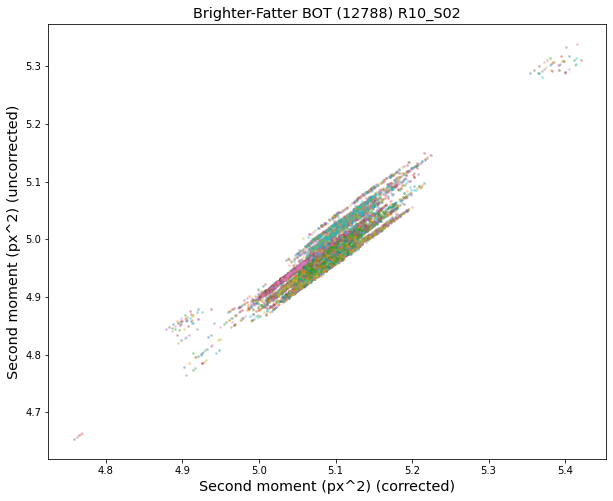

In [17]:
plt.figure(4, figsize=(10,8),facecolor="w")
plt.title("Brighter-Fatter BOT (12788) R10_S02", fontsize='x-large')
 
uncorrected = []
corrected = []
for tc,tuc in zip(tab_corr, tab_uncorr):
    spots = np.intersect1d(tc['spot_indices'], tuc['spot_indices'])
    tmp_corrected = []
    tmp_uncorrected = []
    for pt in spots:
        shape_corrected = tc['base_SdssShape_xx'][np.argwhere(tc['spot_indices'] == pt)]
        shape_uncorrected = tuc['base_SdssShape_xx'][np.argwhere(tuc['spot_indices'] == pt)]
        tmp_corrected.append(shape_corrected)
        tmp_uncorrected.append(shape_uncorrected)
    
    corrected.append(tmp_corrected)
    uncorrected.append(tmp_uncorrected)
    
for i,j in zip(uncorrected, corrected):
    plt.scatter(i, j, s=3, alpha=.3)
plt.xlabel("Second moment (px^2) (corrected)", fontsize='x-large')
plt.ylabel("Second moment (px^2) (uncorrected)", fontsize='x-large')
plt.savefig("./plots/itl-R10_S02-25raft-moredata/polynomialfit/centerspots/secondmoment_secondmoment_corrected_uncorrected.png")




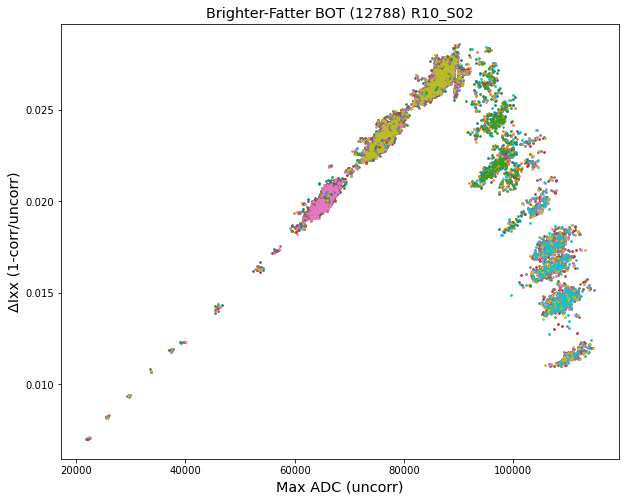

In [18]:
plt.figure(5, figsize=(10,8),facecolor="w")
plt.title("Brighter-Fatter BOT (12788) R10_S02", fontsize='x-large')
 
diffs = []
fluxes = []
for tc,tuc in zip(tab_corr, tab_uncorr):
    spots = np.intersect1d(tc['spot_indices'], tuc['spot_indices'])
    tmp_diffs = []
    tmp_flux = []
    for pt in spots:
        shape_corrected = tc['base_SdssShape_xx'][np.argwhere(tc['spot_indices'] == pt)]
        shape_uncorrected = tuc['base_SdssShape_xx'][np.argwhere(tuc['spot_indices'] == pt)]

        flux = tuc['maxADC'][int(np.argwhere(tuc['spot_indices'] == pt))]
        tmp_diffs.append(1. - shape_corrected/shape_uncorrected)
        tmp_flux.append(flux)
        

    diffs.append(tmp_diffs)
    fluxes.append(tmp_flux)
    
for i,j in zip(fluxes, diffs):
    plt.scatter(i, j, s=3)
plt.xlabel("Max ADC (uncorr)", fontsize='x-large')
plt.ylabel("ΔIxx (1-corr/uncorr)", fontsize='x-large')
plt.savefig("./plots/itl-R10_S02-25raft-moredata/polynomialfit/centerspots/secondmoment_flux_corrected_uncorrected.png")




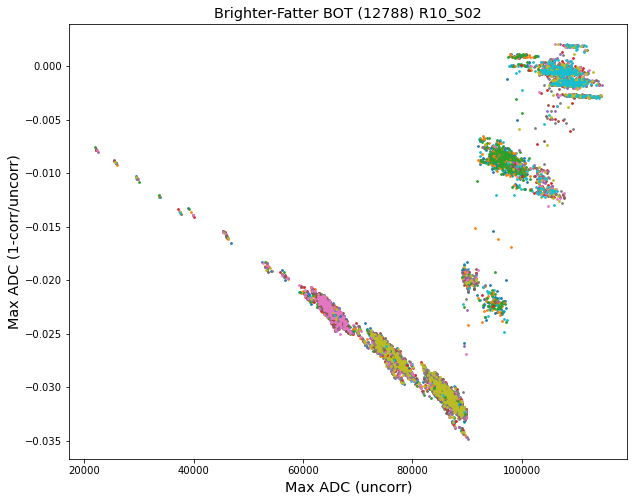

In [19]:
plt.figure(6, figsize=(10,8),facecolor="w")
plt.title("Brighter-Fatter BOT (12788) R10_S02", fontsize='x-large')
 
uncorrected = []
corrected = []
for tc,tuc in zip(tab_corr, tab_uncorr):
    spots = np.intersect1d(tc['spot_indices'], tuc['spot_indices'])
    tmp_corrected = []
    tmp_uncorrected = []
    for pt in spots:
        flux_corrected = tc['maxADC'][int(np.argwhere(tc['spot_indices'] == pt))]
        flux_uncorrected = tuc['maxADC'][int(np.argwhere(tuc['spot_indices'] == pt))]
        tmp_corrected.append(1. - flux_corrected/flux_uncorrected)
        tmp_uncorrected.append(flux_uncorrected)
    
    corrected.append(tmp_corrected)
    uncorrected.append(tmp_uncorrected)
    
for i,j in zip(uncorrected, corrected):
    plt.scatter(i, j, s=3)
plt.xlabel("Max ADC (uncorr)", fontsize='x-large')
plt.ylabel("Max ADC (1-corr/uncorr)", fontsize='x-large')
#plt.ylim(-0.0025,0.0025)
plt.savefig("./plots/itl-R10_S02-25raft-moredata/polynomialfit/centerspots/flux_flux_corrected_uncorrected.png")



In [26]:
# Write data to a pickle

byamp_results = []
byamp_corrected_results = []

    
for i, table in enumerate([tab_corr, tab_uncorr]):
    
    for exp in table.groups:
        flux = exp['base_CircularApertureFlux_70_0_instFlux']
        shape = exp['base_SdssShape_xx']

        if i==0:
            byamp_corrected_results.append([np.sum(exp['numspots']),np.nanmedian(flux), np.nanstd(flux), np.nanmedian(shape), np.nanstd(shape)])
        else:
            byamp_results.append([np.sum(exp['numspots']),np.nanmedian(flux), np.nanstd(flux), np.nanmedian(shape), np.nanstd(shape)])


            
spots_pickle = {'results':byamp_results, 'corrected_results': byamp_corrected_results}
filename = "./plots/itl-R10_S02-25raft-moredata/polynomialfit/centerspots/spots_results_12788_R10_S02.pkl"

if(os.path.isfile(filename)):
    print("Throwing out the old pickle.")
    os.remove(filename)
        
with open(filename, 'wb') as f:
    print("Jarring a new pickle.")
    pkl.dump(spots_pickle, f)
    print("Done.")

Throwing out the old pickle.
Jarring a new pickle.
Done.


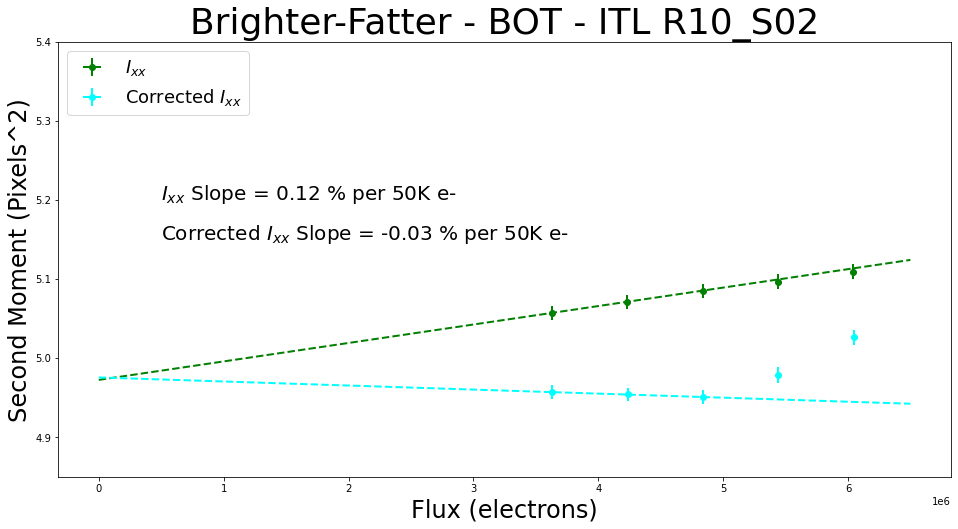

In [6]:
plotCorrection = True
filename = "./plots/itl-R10_S02-25raft-moredata/polynomialfit/centerspots/spots_results_12788_R10_S02.pkl"
with open(filename, 'rb') as f:
    spots_pickle= pkl.load(f)
byamp_results = spots_pickle['results']
if plotCorrection:
    byamp_corrected_results = spots_pickle['corrected_results']

# Now plot the result
plotCorrection=True
syst_fraction = 0.2
min_slope_index = 0
max_slope_index = len(byamp_results) - 1
max_flux_index = len(byamp_results)
minSpot = 5.0
maxSpot = 5.6
textDelta = (maxSpot - minSpot) / 10
# These next are in case not all fluxes produced good results

# [numspots, np.nanmean(flux), np.nanstd(flux), np.nanmean(x2), np.nanstd(x2), np.nanmean(y2), np.nanstd(y2)]
# [d['numspots'], d['fluxmean'], d['fluxerr'], d['shapemean'], d['shapeerr']]

try:
    results = np.array([byamp_results[i] for i in range(max_flux_index)])
    max_slope_ind = max_slope_index
except:
    results = np.array(byamp_results)
    max_slope_ind = min(len(results) - 4, max_slope_index)
xerror = results[:,2]/np.sqrt(results[:,0])
xyerror = results[:,4] * (syst_fraction + (1 - syst_fraction) / np.sqrt(results[:,0]))


if plotCorrection:
    try:
        corrected_results = np.array([byamp_corrected_results[i] for i in range(max_flux_index)])
        max_slope_ind_corr = max_slope_index
    except:
        corrected_results = np.array(byamp_corrected_results)           
        max_slope_ind_corr = min(len(corrected_results) - 4, max_slope_index)

    corrected_xerror = corrected_results[:,2]/np.sqrt(corrected_results[:,0])
    corrected_xyerror = corrected_results[:,4] * (syst_fraction + (1 - syst_fraction) / np.sqrt(corrected_results[:,0]))

plt.figure(7, figsize=(16,8), facecolor='w')
plt.title("Brighter-Fatter - BOT - ITL R10_S02", fontsize = 36)
# First plot the uncorrected data
plt.errorbar(results[:,1], results[:,3], xerr = xerror, yerr = xyerror, color = 'green', lw = 2, label = '$I_{xx}$', ls='', marker='o')

slope, intercept, r_value, p_value, std_err = stats.linregress(results[0:3,1], results[0:3,3])
xplot=np.linspace(0.0,6.5e6,100)
yplot = slope * xplot + intercept
plt.plot(xplot, yplot, color='green', lw = 2, ls = '--')
tslope = slope * 100.0 * 50000.0
plt.text(0.5e6, 5.2, "$I_{xx}$ Slope = %.2f %% per 50K e-"%tslope, fontsize='20')


if plotCorrection:
    # Now plot the corrected data
    plt.errorbar(corrected_results[:,1], corrected_results[:,3], xerr = corrected_xerror, yerr = corrected_xyerror, color = 'cyan', lw = 2, ls='', marker='o', label = 'Corrected $I_{xx}$')

    slope, intercept, r_value, p_value, std_err = stats.linregress(corrected_results[0:3,1], corrected_results[0:3,3])
    xplot=np.linspace(0.0,6.5e6,100)
    yplot = slope * xplot + intercept
    plt.plot(xplot, yplot, color='cyan', lw = 2, ls = '--')
    tslope = slope * 100.0 * 50000.0
    plt.text(0.5e6, 5.15, "Corrected $I_{xx}$ Slope = %.2f %% per 50K e-"%tslope, fontsize='20')

plt.xlabel('Flux (electrons)',fontsize=24)
plt.ylabel('Second Moment (Pixels^2)',fontsize=24)
#plt.xlim(0,1.5e6)
plt.ylim(4.85, 5.4)
plt.legend(loc= 'upper left',fontsize = 18)
plt.savefig("./plots/itl-R10_S02-25raft-moredata/polynomialfit/centerspots/spots_results_12788_R10_S02.png")

Yousuke's plot

<ipython-input-4-f08b0cf84549>:44: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("211")
<ipython-input-4-f08b0cf84549>:56: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  bx = plt.subplot("212",sharex=ax)


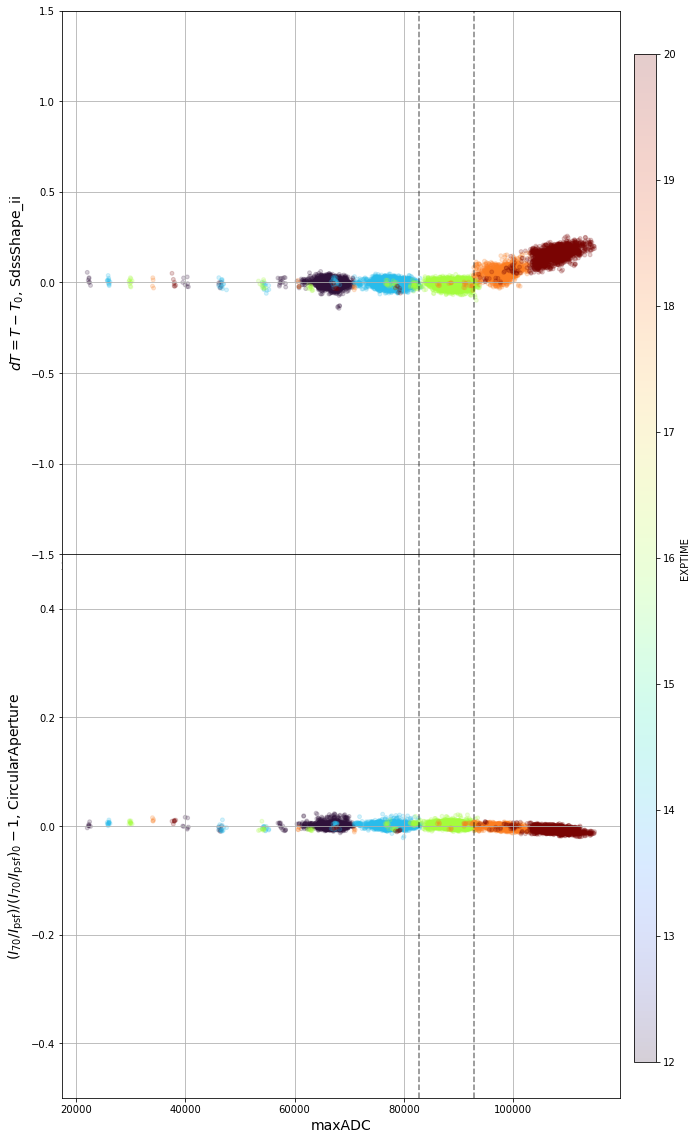

In [4]:
table = tab_corr
ref = table[np.where(table['exptime'] == 12.0)][0]

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14

x = []
y = []
zl = []
zs = []
e = []

for iterable in table:
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], ref['spot_indices'], return_indices=True)

    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
    y.extend( Y1+Y2-(Y0_1+Y0_2) )
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
zl=np.array(zl)
zs=np.array(zs)



# Plot

fig = plt.figure(figsize=(10,20), facecolor='w')
ax = plt.subplot("211")
sca=ax.scatter(x,y,c=e,s=15,cmap='turbo',alpha=0.2)
#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
ax.set_ylabel("{}".format(r"$dT=T-T_0$, SdssShape_ii"),fontsize=fontsize)
#ax.set_xlim(1e5,1e7)
ax.set_ylim(-1.5,1.5)
ax.grid()

bx = plt.subplot("212",sharex=ax)
scb=bx.scatter(x,zs/zl-1,c=e,s=15,cmap='turbo',alpha=0.2)
bx.set_ylabel("{}".format(r"$(I_{70}/I_{\rm psf})/(I_{70}/I_{\rm psf})_0-1$, CircularAperture"),fontsize=fontsize)
#bx.set_xlim(1e5,1e7)
bx.set_ylim(-0.5,0.5)
#plt.semilogx()
bx.grid()
bx.set_xlabel(xkey,fontsize=fontsize)

# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml
for ch in [82733, 92824] :
    ax.axvline(ch, c="k", ls="--", alpha=0.5)
    bx.axvline(ch, c="k", ls="--", alpha=0.5)

#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
plt.colorbar(scb,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.90,hspace=0)
plt.savefig("./plots/itl-R10_S02-25raft-moredata/polynomialfit/centerspots/summary_Ixx+Iyy_BFcorrected.png")



<ipython-input-5-309d9b2de8a8>:44: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot("211")
<ipython-input-5-309d9b2de8a8>:56: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  bx = plt.subplot("212",sharex=ax)


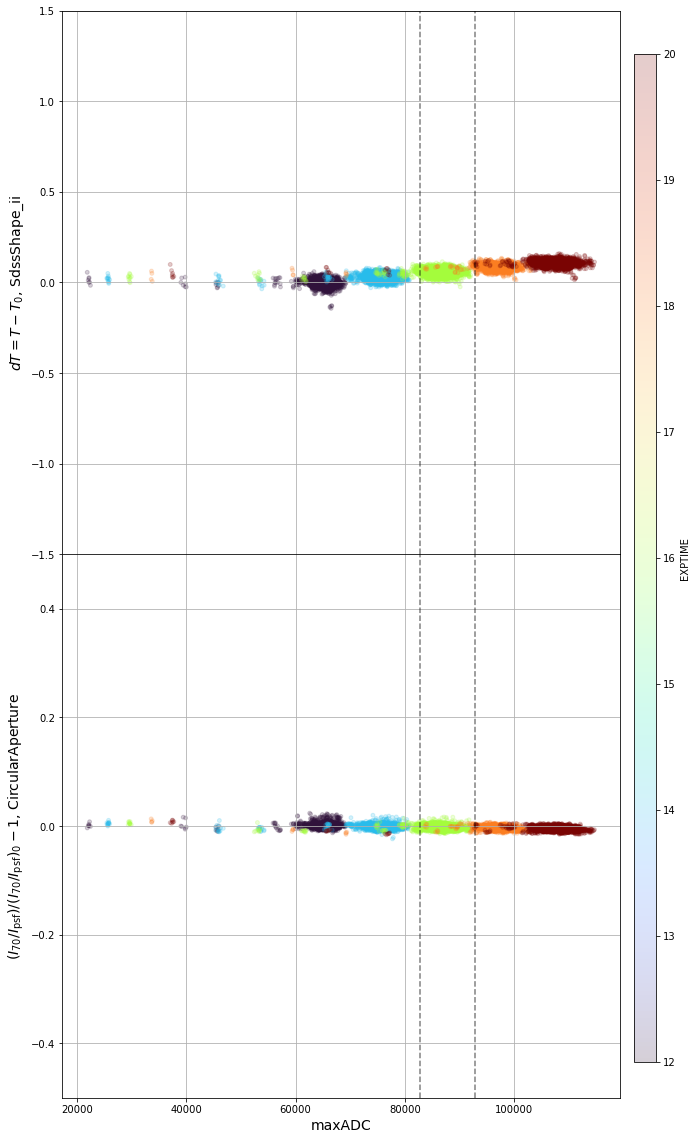

In [5]:
table = tab_uncorr
ref = table[np.where(table['exptime'] == 12.0)][0]

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_CircularApertureFlux_3_0_instFlux"
zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14

x = []
y = []
zl = []
zs = []
e = []

for iterable in table:
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], ref['spot_indices'], return_indices=True)

    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
    y.extend( Y1+Y2-(Y0_1+Y0_2) )
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
zl=np.array(zl)
zs=np.array(zs)



# Plot

fig = plt.figure(figsize=(10,20), facecolor='w')
ax = plt.subplot("211")
sca=ax.scatter(x,y,c=e,s=15,cmap='turbo',alpha=0.2)
#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
ax.set_ylabel("{}".format(r"$dT=T-T_0$, SdssShape_ii"),fontsize=fontsize)
#ax.set_xlim(1e5,1e7)
ax.set_ylim(-1.5,1.5)
ax.grid()

bx = plt.subplot("212",sharex=ax)
scb=bx.scatter(x,zs/zl-1,c=e,s=15,cmap='turbo',alpha=0.2)
bx.set_ylabel("{}".format(r"$(I_{70}/I_{\rm psf})/(I_{70}/I_{\rm psf})_0-1$, CircularAperture"),fontsize=fontsize)
#bx.set_xlim(1e5,1e7)
bx.set_ylim(-.5,.5)
#plt.semilogx()
bx.grid()
bx.set_xlabel(xkey,fontsize=fontsize)

# Plot the min and max ptc turnoffs for this sensor
#    from: https://github.com/lsst/obs_lsst/blob/master/policy/lsstCam/R10.yaml
for ch in [82733, 92824] :
    ax.axvline(ch, c="k", ls="--", alpha=0.5)
    bx.axvline(ch, c="k", ls="--", alpha=0.5)

#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
plt.colorbar(scb,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.90,hspace=0)
plt.savefig("./plots/itl-R10_S02-25raft-moredata/polynomialfit/centerspots/summary_Ixx+Iyy_NOT-BFcorrected.png")

<ipython-input-6-f922971a31b3>:56: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  bx = plt.subplot("111",sharex=ax)


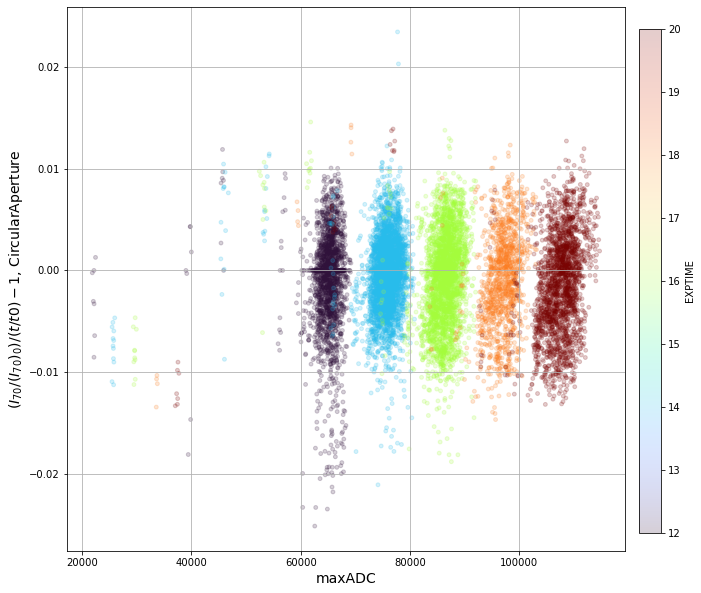

In [6]:
table = tab_uncorr
ref = table[np.where(table['exptime'] == 12.0)][0]

y1key="base_SdssShape_xx"
y2key="base_SdssShape_yy"
xkey="maxADC"
#xkey="base_CircularApertureFlux_70_0_instFlux"
zskey="base_CircularApertureFlux_70_0_instFlux"
#zskey="base_PsfFlux_instFlux"
zlkey="base_CircularApertureFlux_70_0_instFlux"

fontsize=14

x = []
y = []
zl = []
zs = []
e = []

for iterable in table:
    spots, iter_ind, ref_ind = np.intersect1d(iterable['spot_indices'], ref['spot_indices'], return_indices=True)

    x.extend(iterable[xkey][iter_ind])
    Y1=iterable[y1key][iter_ind]
    Y2=iterable[y2key][iter_ind]
    Y0_1=ref[y1key][ref_ind]
    Y0_2=ref[y2key][ref_ind] 
    
    zl.extend(iterable[zlkey][iter_ind]/ref[zlkey][ref_ind])
    zs.extend(iterable[zskey][iter_ind]/ref[zskey][ref_ind])
    y.extend( Y1+Y2-(Y0_1+Y0_2) )
    e.extend([iterable['exptime']]*len(Y1))

x=np.array(x)
y=np.array(y)
zl=np.array(zl)
zs=np.array(zs)



# Plot

fig = plt.figure(figsize=(10,10), facecolor='w')
#ax = plt.subplot("111")
#sca=ax.scatter(x,y,c=e,s=15,cmap='turbo',alpha=0.2)
#ax.scatter(x2,y2,c="r", s=15)

"""for i in range(len(e2)):
    if (x2[i] >= 1e5) and (x2[i] <= 1e7) and (np.abs(y2[i]) <= 0.4):
        ax.text(x2[i],y2[i]+0.0075,str(e2[i]), c="red")"""
#ax.set_ylabel("{}".format(r"$dT=T-T_0$, SdssShape_ii"),fontsize=fontsize)
#ax.set_xlim(1e5,1e7)
#ax.set_ylim(-1.,2.5)
#ax.grid()
e = np.asarray(e)
bx = plt.subplot("111",sharex=ax)
scb=bx.scatter(x,(zs/(e/12.))-1,c=e,s=15,cmap='turbo',alpha=0.2)
bx.set_ylabel("{}".format(r"$(I_{70}/(I_{70})_0) / (t/t0)-1$, CircularAperture"),fontsize=fontsize)
#bx.set_xlim(1e5,1e7)
#bx.set_ylim(-0.5,0.8)
#plt.semilogx()
bx.grid()
bx.set_xlabel(xkey,fontsize=fontsize)


#plt.colorbar(scb,label="EXPTIME",orientation="horizontal",location="bottom")

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
plt.colorbar(scb,cax=cbar_ax,label="EXPTIME")

plt.subplots_adjust(right=0.90,hspace=0)
plt.savefig("./plots/itl-R10_S02-25raft-moredata/polynomialfit/centerspots/summary_I70_I70.png")

Text(0.5, 0, 'Shape (px^2)')

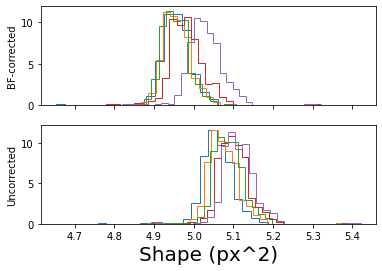

In [26]:
fig, axs = plt.subplots(2,1, sharex=True)
for group in tab_corr.groups:
    axs[0].hist(group['base_SdssShape_xx'].flatten(), bins=30, density=True, histtype='step')
    axs[0].set_ylabel("BF-corrected")
for group in tab_uncorr.groups:
    axs[1].hist(group['base_SdssShape_xx'].flatten(), bins=30, density=True, histtype='step')
    axs[1].set_ylabel("Uncorrected")

axs[1].set_xlabel("Shape (px^2)", fontsize=20)